In [52]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ( confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from typing import List, Dict
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from xgboost import XGBClassifier


In [2]:
data = pd.read_csv("telescope_data.csv")

In [3]:
def clean_column_names (col_name) -> str:
    return re.sub(r'^f', '', col_name)


def toInt (col) -> int:
    return 1 if col == 'g' else 0

In [4]:
data.rename(columns={col: clean_column_names(col) for col in data.columns}, inplace=True)

data.rename(columns={"class": "Class"}, inplace=True)

data.drop("Unnamed: 0", axis=1, inplace=True)

data.Class = data.Class.apply(toInt)


KeyboardInterrupt: 

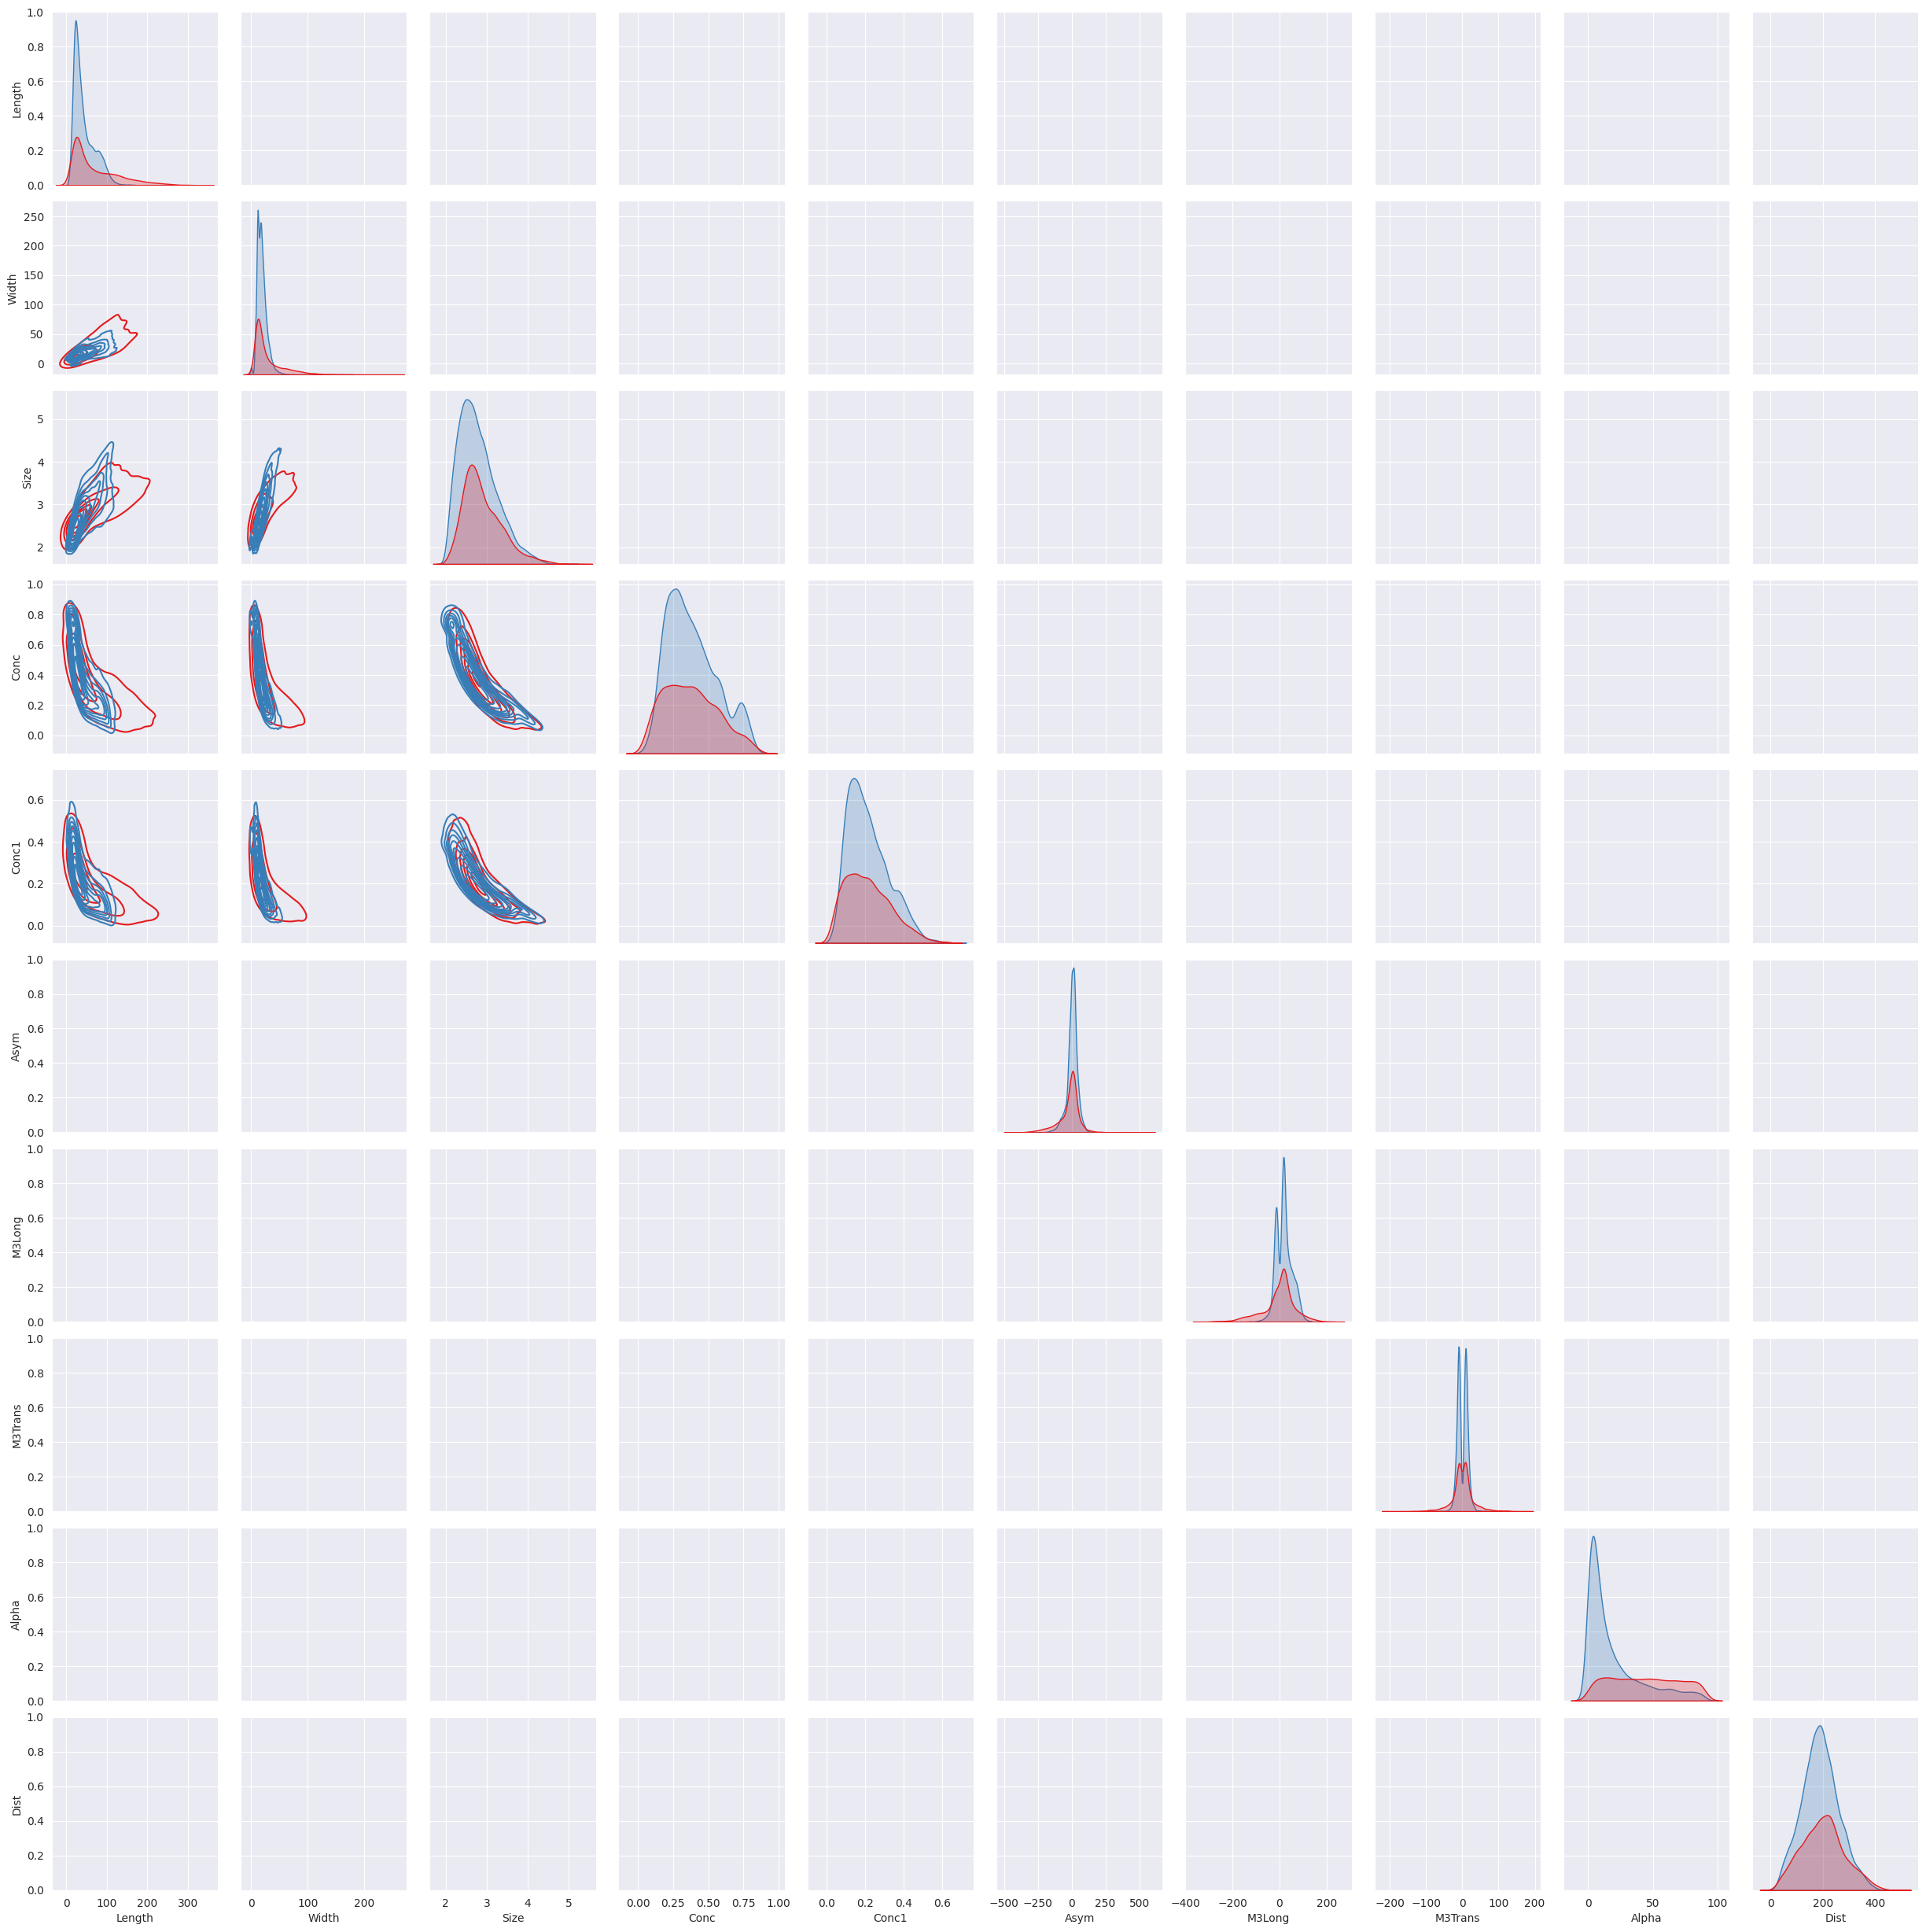

In [5]:
sns.pairplot(data, hue="Class", kind="kde", palette="Set1")
plt.show()

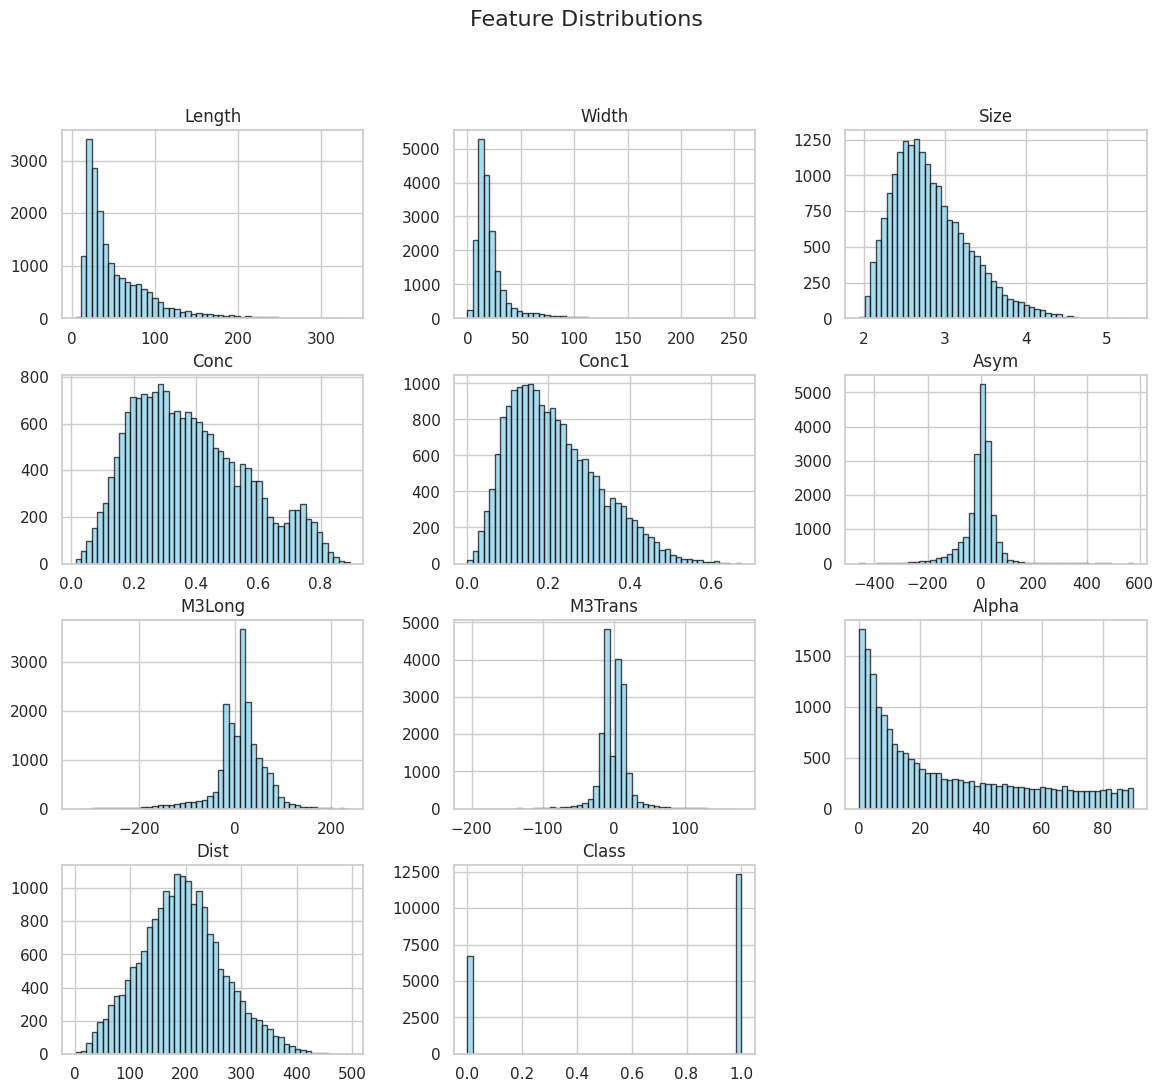

In [6]:
sns.set(style="whitegrid")
data.hist(figsize=(14, 12), bins=50, edgecolor="black", color="skyblue", alpha=0.7)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

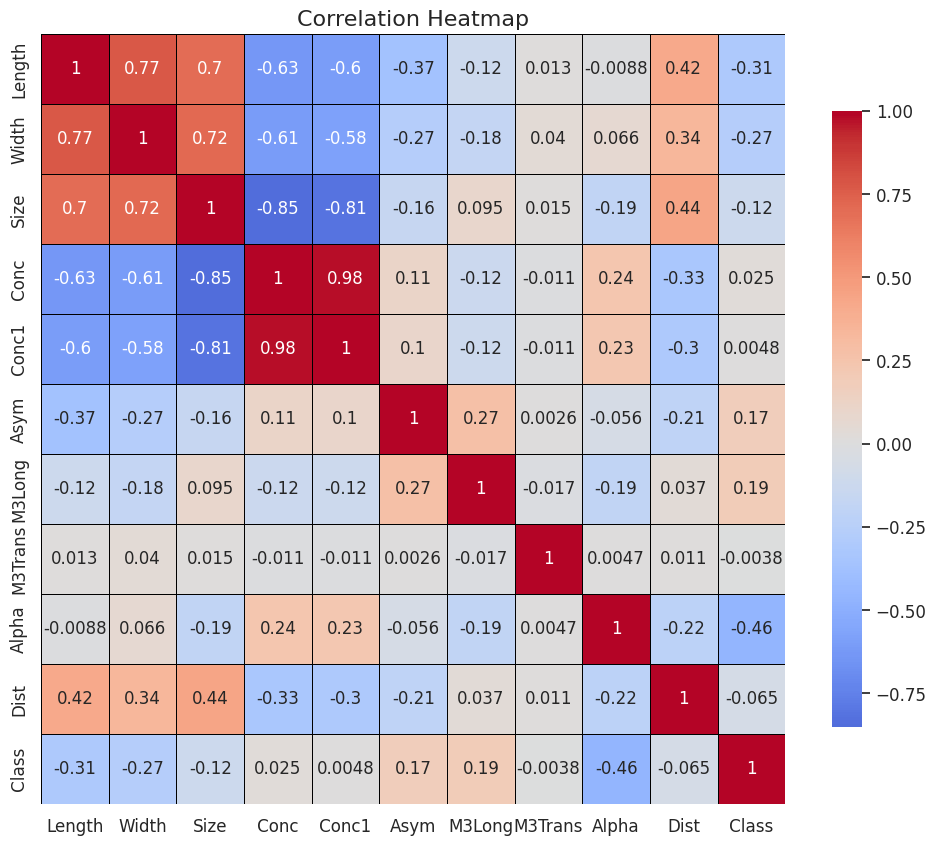

In [68]:
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.1)
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm",
            center=0, linewidths=0.5, linecolor="black",
            cbar_kws={"shrink": 0.8}, annot_kws={"size": 12})
plt.title("Correlation Heatmap", fontsize=16)

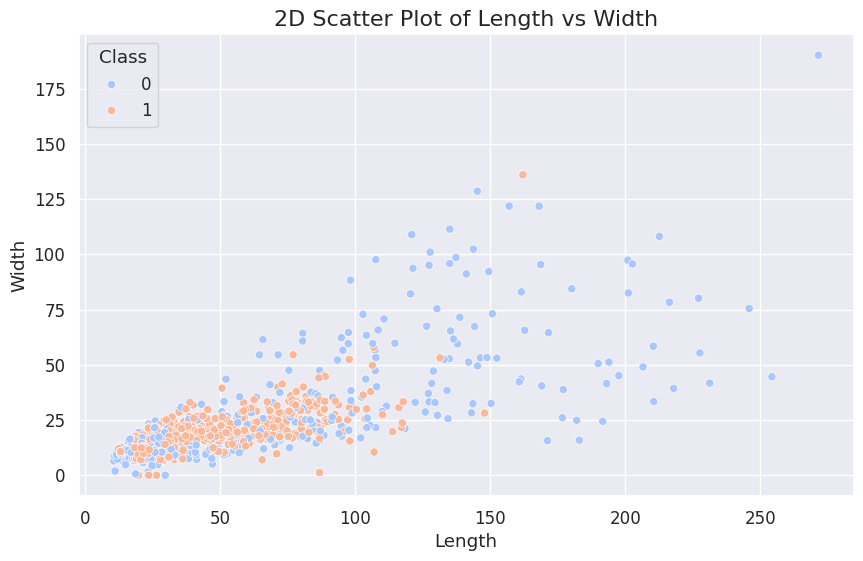

In [69]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Length", y="Width", hue="Class", data=data.sample(1000), palette="coolwarm")
plt.title("2D Scatter Plot of Length vs Width", fontsize=16)
plt.show()


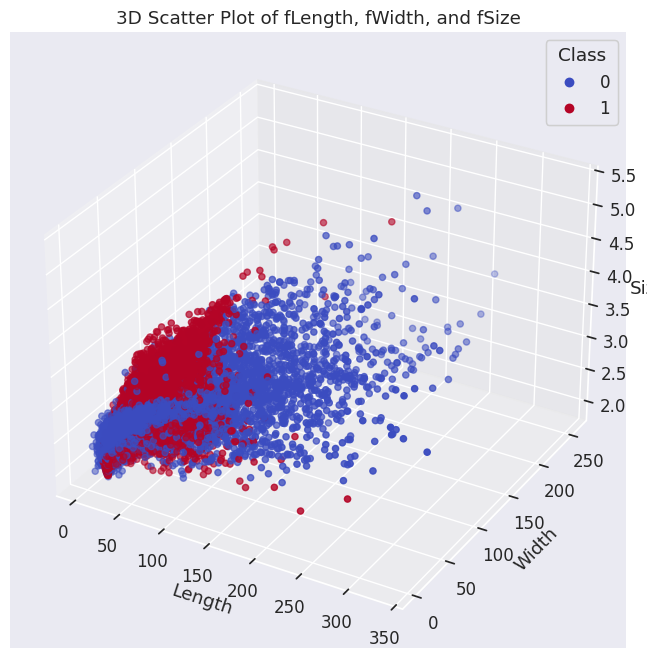

In [70]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(data.Length, data.Width, data.Size, c=data.Class, cmap="coolwarm")
legend1 = ax.legend(*scatter.legend_elements(), title="Class")
ax.add_artist(legend1)
ax.set_xlabel("Length")
ax.set_ylabel("Width")
ax.set_zlabel("Size")
plt.title("3D Scatter Plot of Length, Width, and Size")
plt.show()

In [7]:
x = data.drop("Class", axis=1)
y = data.Class

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [10]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [11]:
y_train.value_counts()

Class
1    8627
0    4687
Name: count, dtype: int64

In [36]:
def print_metrics (model_list: List) -> Dict:
    global y_test
    global x_test_scaled
    metrics_dict: Dict = {}
    
    for model in model_list:
        if 'keras' in str(type(model)).lower():
            x_test_array = np.array(x_test_scaled)
            preds_proba = model.predict(x_test_array)
            preds = (preds_proba > 0.5).astype(int).flatten()
        else:
            preds = model.predict(x_test_scaled)
            if preds.ndim > 1 and preds.shape[1] == 1:
                preds = (preds > 0.5).astype(int).flatten()
        
        accuracy = accuracy_score(y_test, preds)
        precision = precision_score(y_test, preds, average="macro")
        f1 = f1_score(y_test, preds, average="macro")
        recall = recall_score(y_test, preds, average="macro")
        conf_matrix = confusion_matrix(y_test, preds)
        roc_auc = roc_auc_score(y_test, preds, multi_class="ovr") if len(set(y_test)) > 2 else roc_auc_score(y_test,
                                                                                                             preds)
        
        metrics_dict[model.__class__.__name__] = {
            "Accuracy Score": accuracy,
            "Precision Score": precision,
            "F1 Score": f1,
            "Recall Score": recall,
            "Confusion Matrix": conf_matrix.tolist(),
            "ROC AUC Score": roc_auc
        }
    
    return metrics_dict


In [37]:
param_grid = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "criterion": ["gini", "entropy"]
}

In [38]:
models: List = []

In [39]:
logistic_model = LogisticRegression(random_state=42, max_iter=5000)
logistic_model.fit(x_train_scaled, y_train)
models.append(logistic_model)

In [40]:
decision_tree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1,
                           verbose=True)
grid_search.fit(x_train_scaled, y_train)
best_tree = grid_search.best_estimator_
models.append(best_tree)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [41]:
random_forest = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
random_forest.fit(x_train_scaled, y_train)
models.append(random_forest)

In [42]:
gradient_boost = GradientBoostingClassifier(random_state=42)
gradient_boost.fit(x_train_scaled, y_train)
models.append(gradient_boost)

In [44]:
ada_boost = AdaBoostClassifier(random_state=42, algorithm="SAMME")
ada_boost.fit(x_train_scaled, y_train)
models.append(ada_boost)

In [45]:
xg_boost = XGBClassifier(random_state=42)
xg_boost.fit(x_train_scaled, y_train)
models.append(xg_boost)

In [49]:
X_train_scaled = np.array(x_train_scaled)
X_test_scaled = np.array(x_test_scaled)
neural_net = Sequential()
neural_net.add(Input(shape=(x_train.shape[1],)))
neural_net.add(Dense(128, activation="relu"))
neural_net.add(Dropout(0.5))
neural_net.add(Dense(64, activation="relu"))
neural_net.add(Dense(1, activation="sigmoid"))
neural_net.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = neural_net.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
models.append(neural_net)

Epoch 1/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7581 - loss: 0.5035 - val_accuracy: 0.8273 - val_loss: 0.3838
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8299 - loss: 0.3899 - val_accuracy: 0.8479 - val_loss: 0.3617
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.8391 - loss: 0.3754 - val_accuracy: 0.8490 - val_loss: 0.3495
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.8491 - loss: 0.3618 - val_accuracy: 0.8543 - val_loss: 0.3422
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.8618 - loss: 0.3416 - val_accuracy: 0.8626 - val_loss: 0.3407
Epoch 6/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.8550 - loss: 0.3425 - val_accuracy: 0.8588 - val_loss: 0.3372
Epoch 7/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.8598 - loss: 0.3392 - val_accuracy: 0.8599 - val_loss: 0.3314
Epoch 8/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8535 - loss: 0.3445 - val_ac

In [50]:
metrics = print_metrics(models)
simple_metrics = {model: {k: v for k, v in metrics[model].items() if isinstance(v, (int, float))} for model in metrics}
metrics_data = pd.DataFrame.from_dict(simple_metrics, orient='index')

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step


In [51]:
metrics_data

,Accuracy Score,Precision Score,F1 Score,Recall Score,ROC AUC Score
LogisticRegression,0.793551,0.785502,0.758643,0.746560,0.746560
DecisionTreeClassifier,0.848756,0.844496,0.827548,0.816881,0.816881
RandomForestClassifier,0.878023,0.874625,0.862449,0.853668,0.853668
GradientBoostingClassifier,0.872064,0.875875,0.853019,0.839426,0.839426
AdaBoostClassifier,0.827725,0.818178,0.804331,0.795400,0.795400
XGBClassifier,0.881703,0.879403,0.866439,0.857192,0.857192
Sequential,0.871889,0.874474,0.853178,0.840211,0.840211
